# Computing Jaccard Index Similarities between Models based on their SHAP Features and Scores

Author: Tesfagabir Meharizghi<br>
Last Updated: 01/05/2021

This notebook implements the following actions:
- Computes and saves SHAP values using different trained models (Simple LSTM, LSTM+Attention and XGB).
    * The number of background examples are configured. E.g., 500
    * Whether to use only negative examples as background
    * Since the SHAP value computation is slow, it also specifies the number of examples for test (N_TEST)
- It also computes the Jaccard similarity index between each model's shap values and visualizes it in HEATMAPS
    * It visualizes for different number of top k features
- It also computes the intersection similarity value between the ground truth helping events (helpers with suffix `_H` and Adverse with suffix `_A`) and the predicted helping events for each model.

Requirements:
- Please make sure that all the models are already trained and saved. You can use the [02_ToySimple_lstm-attn-training-shap-jacc.ipynb](02_ToySimple_lstm-attn-training-shap-jacc.ipynb) notebook to train and save the models

Data Used:
- It uses the toy_simple dataset with different sequence lengths (30, 300, 900)
- Sequence Lengths: 30, 300, 900
- Train Size: 18K, Val Size: 6K, Test Size: 6K

Observations of experiments
- The performances of the different models looks similar
- The intersection similarities results for the different sequence lengths were not consistent 

Any actions/next steps/thoughts/discussion
- As we couldn't get clear conclusions from these results, we will deep dive into the model training, parameter tuning, etc. as the next action item.
- For each model architecture, we will explore more on every step from model training, tuning, overtraining, shap values, intersection similarities, etc.
- Separate ipynbs are created for each model. E.g., go to [02_ToySimple_lstm-attn-training-shap-jacc.ipynb](02_ToySimple_lstm-attn-training-shap-jacc.ipynb) to check the results for LSTM+Attention model analysis



In [ ]:
# pip install nb-black

In [4]:
#! jupyter nbextension enable jupyter-black-master/jupyter-black

#! pip install botocore==1.12.201

#! pip install shap
#! pip install xgboost

In [5]:
%load_ext lab_black

%load_ext autoreload

%autoreload 2

In [6]:
import os
import time
import torch
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from urllib.parse import urlparse
import tarfile
import pickle
import shutil

import shap
import xgboost as xgb

import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.image_uris import retrieve

import deep_id_pytorch

import shap_jacc_utils as sj_utils

## Constants

In [7]:
seq_lens = [30, 300]  # , 900] TODO: Update here
model_names = ["lstm", "lstm-att"]  # , 'xgb'] TODO: update for xgb too.
shap_dir_pattern = "./output/{}/{}/shap/"  # seq_len, model_name

k_list = range(1, 11)

In [8]:
def load_model_test_shap(shap_dir_pattern, seq_len, model_name):
    """Loads the final shap values (features, scores, patient_ids) of a models for the test set."""
    model_shap_dir = shap_dir_pattern.format(seq_len, model_name)
    if not os.path.exists(model_shap_dir):
        raise ValueError(f"Error! {model_shap_dir} does not exist!")
    shap_fnames = os.listdir(model_shap_dir)
    shap_fnames = [
        fname
        for fname in shap_fnames
        if (fname.endswith(".pkl") and fname.startswith("test_"))
    ]
    if not shap_fnames:
        raise ValueError("Error! There is no shap values for the test set.")

    model_shap_path = os.path.join(model_shap_dir, shap_fnames[0])
    model_shap_values = sj_utils.load_pickle(model_shap_path)
    return model_shap_values, model_shap_path

def load_xgb_model_test_shap(shap_dir_pattern, seq_len, hpo_results_path):
    """Loads the final shap values (features, scores, patient_ids) of the xgb model's for the test set."""
    df = pd.read_csv(hpo_results_path)
    best_model_info = get_best_model_info(df)
    job_name = best_model_info
    model_shap_dir = shap_dir_pattern.format(seq_len, model_name)
    if not os.path.exists(model_shap_dir):
        raise ValueError(f"Error! {model_shap_dir} does not exist!")
    shap_fnames = os.listdir(model_shap_dir)
    shap_fnames = [
        fname
        for fname in shap_fnames
        if (fname.endswith(".pkl") and fname.startswith("test_"))
    ]
    if not shap_fnames:
        raise ValueError("Error! There is no shap values for the test set.")

    model_shap_path = os.path.join(model_shap_dir, shap_fnames[0])
    model_shap_values = sj_utils.load_pickle(model_shap_path)
    return model_shap_values, model_shap_path

Jaccard Similarities for seq_len=30...


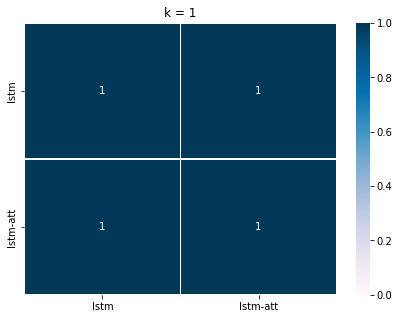

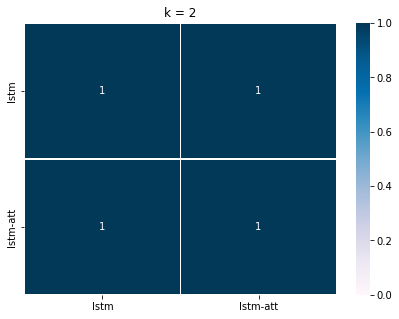

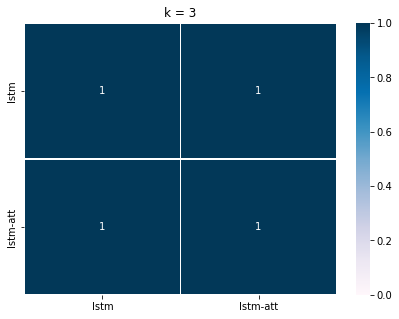

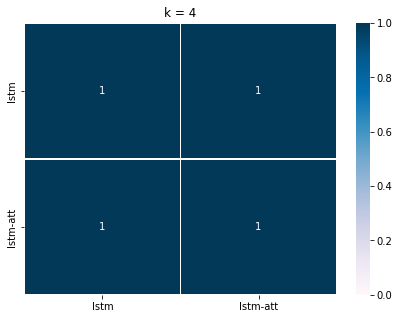

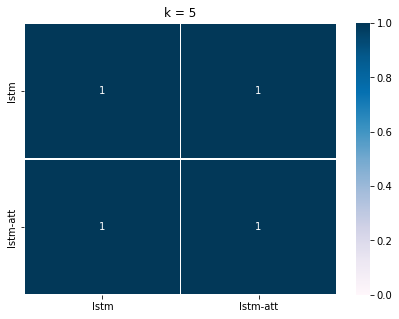

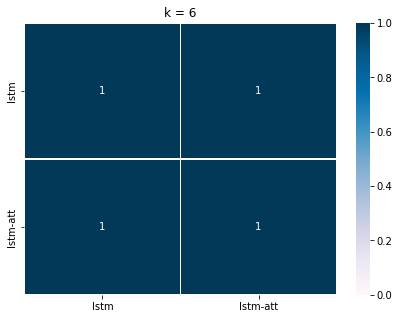

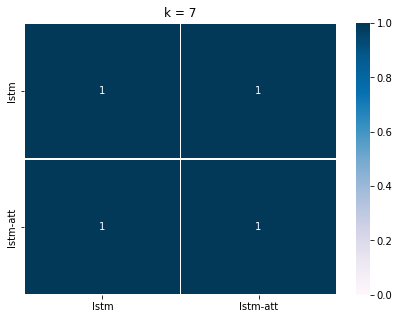

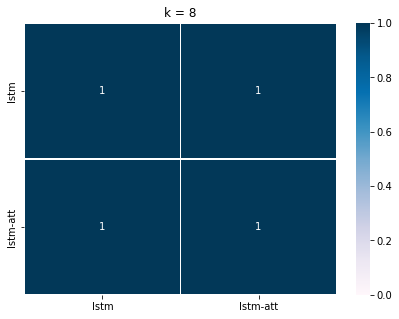

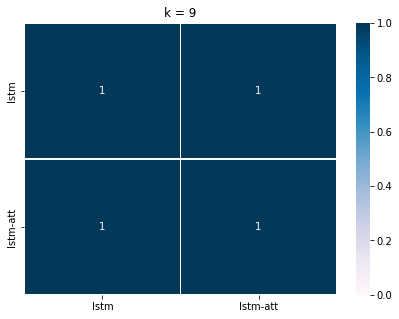

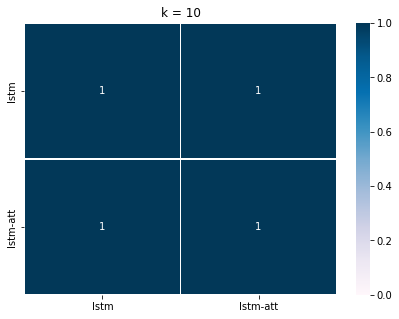

Jaccard Similarities for seq_len=300...


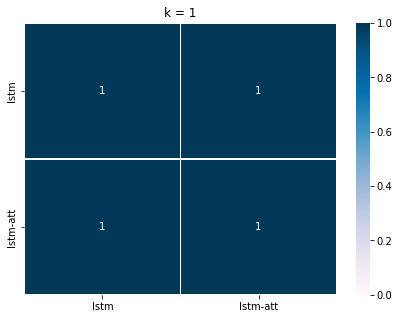

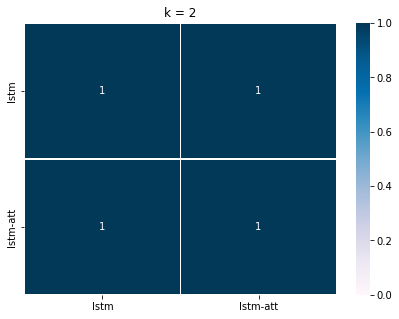

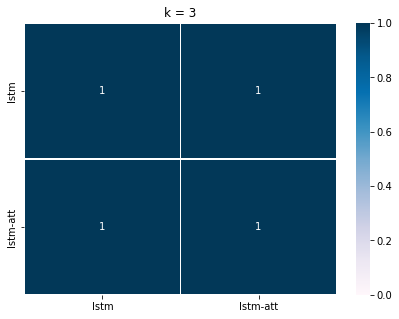

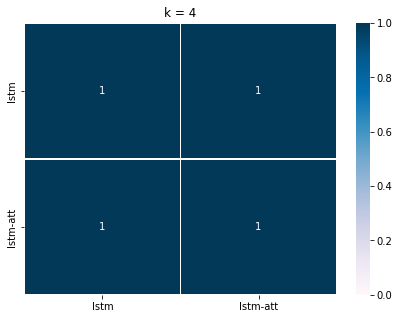

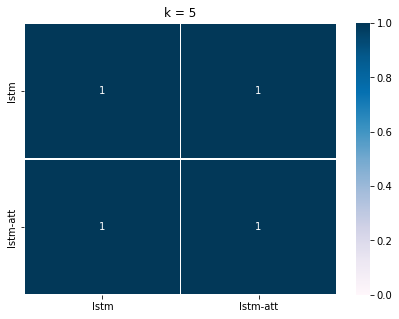

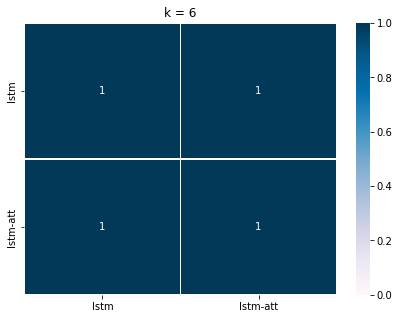

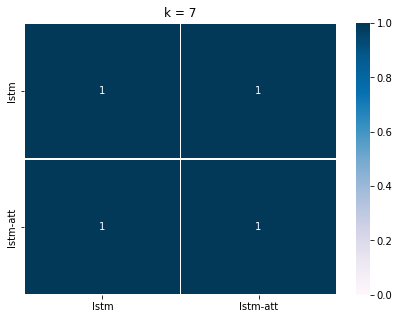

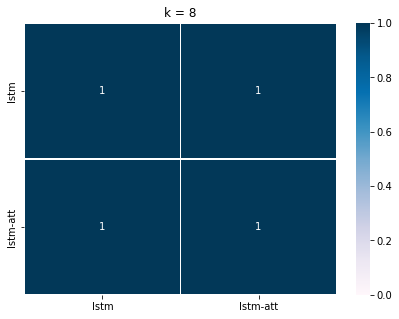

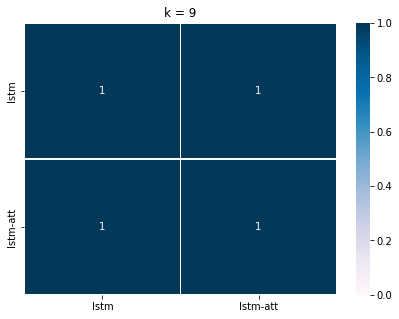

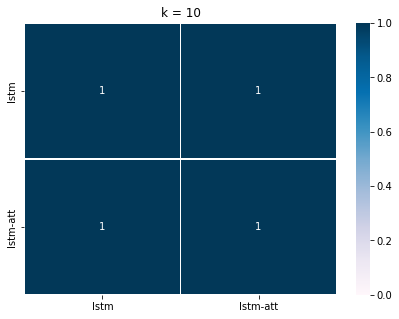

In [10]:
for seq_len in seq_lens:
    print(f"Jaccard Similarities for seq_len={seq_len}...")
    all_shap_values = []
    for model_name in model_names:
        # Load the saved shap values
        shap_values, _ = load_model_test_shap(shap_dir_pattern, seq_len, model_name)
        all_shap_values.append(shap_values)
    sj_utils.generate_k_heatmaps(all_shap_values, model_names, k_list)